In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit

The TRUE wave equation (with damping and stress-strain coupling):

$$\frac{\partial^2 y}{\partial x^2} - \frac{1}{c^2}\frac{\partial^2 y}{\partial t^2} - \gamma \frac{\partial y}{\partial t} -l^2 \frac{\partial^4 y}{\partial x^4} = 0 $$

$$ y(0, t) = y(L, t) = 0 $$
$$ y(x, 0) = f(x) $$

$y$ is the amplitude of the string, $x$ is the location of the string, and $t$ is time.

Parameters:

* $c$: speed of the wave $[m/s]$
* $\gamma$: damping constant $[s/m]$
* $l$: characteristic length (stiffness term) [dimensionless]

Discrete form:

$$\frac{y_{j+1}^{m} -2y_j^m + y_{j-1}^{m}}{\Delta x^2} - \frac{1}{c^2}\frac{y_j^{m+1} -2y_j^m + y_j^{m-1}}{\Delta t^2} - \gamma \frac{y_j^{m+1} - y_j^{m-1}}{2 \Delta t} - l^2 \frac{y_{j-2}^m -4y_{j-1}^m +4y_{j}^m -4y_{j+1}^m +y_{j+2}^m}{\Delta x^4} =0 $$ 

Solve for $y_j^{m+1}$ (the amplitude of the string at the next time):

$$y_j^{m+1} = \left[\frac{1}{c^2 \Delta t^2} + \frac{\gamma}{2 \Delta t} \right]^{-1} \left[\frac{1}{\Delta x^2} \left( y_{j+1}^{m} -2y_j^m + y_{j-1}^{m} \right) -\frac{1}{c^2 \Delta t^2} \left( y_j^{m-1} - 2y_j^m \right) + \frac{\gamma}{2 \Delta t}y_j^{m-1} -\frac{l^2}{\Delta x^4} \left( y_{j-2}^m -4y_{j-1}^m +6y_{j}^m -4y_{j+1}^m +y_{j+2}^m \right) \right] $$

In order for this to be stable, need $c \Delta t/\Delta x < 1$

# Solving

Guitar string length  $\boxed{L = 0.7~\text{m}}$

Choose $\boxed{N_x=101}$ guitar string positions $\implies$ $\boxed{\Delta x = 0.7~\text{mm}}$

Note that the fundamental frequency of a guitar note is $f = c/2L$. With an "A note" at 220Hz get $\boxed{c = 308~\text{m/s}} $

To obey our constraint we thus set $\boxed{\Delta t = 5 \times 10^{-6} s}$. In order to get multiple seconds of a result, choose $\boxed{N_t = 500000}$

Two parameters that seemed to give a solution that sounded like a string were $\boxed{l= 2 \times 10^{-6}}$ and $\boxed{\gamma = 2.6 \times 10^{-5} s/m}$



In [110]:
Nx = 101
Nt = 500000
L =0.7
dx = L/(Nx-1)
f = 220
c = 2*L*f
dt = 5e-6
l=5e-5
gamma=5e-5

Initial state of the string:

In [111]:
ya = np.linspace(0, 0.01, 70)
yb = np.linspace(0.01, 0, 31)
y0 = np.concatenate([ya, yb])

Create 2D array of $y(x, t)$

In [112]:
sol = np.zeros((Nt, Nx))

Make the solution at $t=0$ and $t=1$ equal to the "pluck"

In [113]:
sol[0] = y0
sol[1] = y0

Go through the iterative procedure:

In [114]:
@numba.jit("f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8)", nopython=True, nogil=True)
def compute_d(d, times, length, dt, dx, l, gamma):
    for t in range(1, times-1):
        for i in range(2, length-2):
            outer_fact = (1/(c**2 * dt**2) + gamma/(2*dt))**(-1)
            p1 = 1/dx**2 * (d[t][i-1] - 2*d[t][i] + d[t][i+1])
            p2 = 1/(c**2 * dt**2) * (d[t-1][i] - 2*d[t][i])
            p3 = gamma/(2*dt) * d[t-1][i]
            p4 = l**2 / dx**4 * (d[t][i+2] - 4*d[t][i+1] + 6*d[t][i] - 4*d[t][i-1] + d[t][i-2])
            d[t+1][i] = outer_fact * (p1 - p2 + p3 - p4)
    return d

In [115]:
sol = compute_d(sol, Nt, Nx, dt, dx, l, gamma)

Plot the string at some sample points

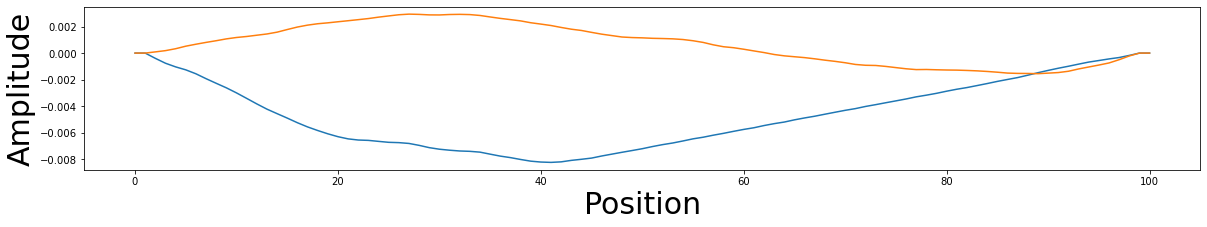

In [116]:
plt.figure(figsize=(20,3))
plt.plot(sol[500])
plt.plot(sol[10000])
plt.xlabel('Position', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.savefig('../output/sample.png')

Make an animation of the string: (1/dt is fps)

In [117]:
len(sol[::10,:])

50000

So 200000 fps. Lets only index every 10 frames which gives 20000 fps. If we choose a gif fps of 20, this means our animation is moving 1000x slower than real life

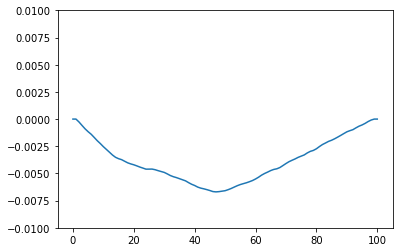

In [118]:
def animate(i):
    ax.clear()
    ax.plot(sol[i*10])
    ax.set_ylim(-0.01, 0.01)
    
fig, ax = plt.subplots(1,1)
ax.set_ylim(-0.01, 0.01)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('string.gif',writer='pillow',fps=20)

# Create .WAV file of noise

Extract the "amount" of the harmonics at any time $t$:

$$ \text{Amplitude of harmonic n at time t} \propto \int_{0}^L y(x, t) \sin(n \pi x / L) dx $$

In [119]:
# This is the way I did it in the video
def get_integral(n):
    sin_arr = np.sin(n*np.pi*np.linspace(0,1,101))
    return np.array([sum(sin_arr*s) for s in sol])

# This is the same as the function above. but runs WAAYYY faster. Use this instead; it is far more optimized
def get_integral_fast(n):
    sin_arr = np.sin(n*np.pi*np.linspace(0,1,101))
    return np.multiply(sol, sin_arr).sum(axis=1)

In [120]:
hms = [get_integral_fast(n) for n in range(10)]

Add them together

In [126]:
all_harmonics=True
if all_harmonics:
    tot = sol.sum(axis=1)[::10] # all harmonics
else:
    tot = sum(hms)[::10] # only first 10 harmonics
tot = tot.astype(np.float32)

Make a WAV file

In [127]:
from scipy.io import wavfile
from IPython.display import Audio

In [128]:
wavfile.write('sound.wav',20000,tot)

In [129]:
Audio('sound.wav')

# Only on my computer: You will have to create these files

In [17]:
from scipy.io.wavfile import read
a = read('../output/v3_Al.wav')[1]
c = read('../output/v3_Csl.wav')[1]
f = read('../output/v3_Fsl.wav')[1]
d = read('../output/v3_D.wav')[1]

In [18]:
wavfile.write('../output/v3_Al+Csl.wav',20000,a+2*c)

In [19]:
Audio('../output/v3_Al+Csl.wav')

In [20]:
a = np.append(a, np.zeros(14000))
c = np.concatenate([np.zeros(1000), c, np.zeros(14000-1000)])
d = np.append(np.zeros(14000), d)
f = np.concatenate([np.zeros(14000-1000), f, np.zeros(1000)])
tot = a + c + d + 0.4*f
tot = tot.astype(np.float32)

In [21]:
wavfile.write('../output/v3_Al+Csl+D.wav',20000,tot)

In [22]:
Audio('../output/v3_Al+Csl+D.wav')

# Alternative Solution

IN PROGRESS: NOT WORKING YET

As recommended by https://www.reddit.com/r/Physics/comments/miabsi/solving_the_full_damping_stressstrain_wave/gt434hj?utm_source=share&utm_medium=web2x&context=3

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [107]:
L = 0.7
f = 220
c = 2*L*f 
l=2e-6
gamma=2.6e-5
N = 101
dx = L/(N+1)
x = np.arange(0, L, N)

In [108]:
l = 0
gamma = 0

Wave numbers

In [109]:
kappa = 2 * np.pi * np.fft.fftfreq(N, dx)

In [110]:
np.pi / L

4.487989505128276

Initial Condition

In [139]:
ya = np.linspace(0, 0.01, 30)
yb = np.linspace(0.01, 0, 21)
y0 = np.concatenate([ya, yb[:-1], np.array([0]), -np.flip(yb)[1:], -np.flip(ya)])
#y0 = 1e-3 * np.sin(np.pi*np.linspace(-1, 1, N))
y0_h = np.fft.fft(y0)

In [140]:
y0_h_ri = np.concatenate((y0_h.real, y0_h.imag))
z0_h_ri = np.zeros(len(y0_h_ri))
S0 = np.concatenate([y0_h_ri, z0_h_ri])

C:\Users\lukep\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


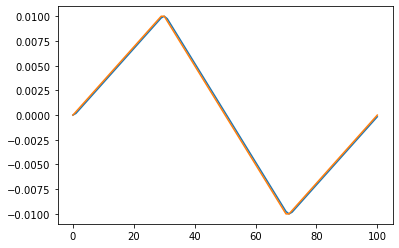

In [143]:
plt.plot(np.fft.ifft(1j * y0_h.imag))
plt.plot(y0)

Our equation becomes

$$\frac{\partial \hat{y}}{\partial t} = \hat{z} $$

$$\frac{\partial \hat{z}}{\partial t} = -c^2 \gamma \hat{z} - c^2 k ^2 (1+k^2 l^2)\hat{y} $$

Let $S=(\hat{y}, \hat{z})$

In [144]:
def dSdt(S, t, k):
    y_h_ri = S[:2*N]; z_h_ri = S[2*N:]
    y_h = 0*y_h_ri[:N] + (1j) * y_h_ri[N:]
    z_h = 0*z_h_ri[:N] + (1j) * z_h_ri[N:]
    dy_h = z_h
    dz_h = -c**2 * gamma * z_h - c**2 * k**2 * (1+(k**2) * (l**2)) * y_h
    dy_hri = np.concatenate([dy_h.real, dy_h.imag])
    dz_hri = np.concatenate([dz_h.real, dz_h.imag])
    return np.concatenate([dy_hri, dz_hri])

In [145]:
dt = 5e-6
t = np.arange(0, 0.025, dt)
sol = odeint(dSdt, y0=S0, t=t, args=(kappa,))

In [146]:
y_h = sol.T[:N] + (1j) * sol.T[N:2*N]
y = np.zeros_like(y_h)
for k in range(len(t)):
    y[:,k] = np.fft.ifft(y_h[:,k]).real
y = y.real

In [147]:
y

array([[-6.50521303e-19, -2.16840434e-18, -4.33680869e-19, ...,
        -8.67361738e-19, -4.33680869e-19, -1.08420217e-18],
       [ 3.44827586e-04,  3.50354508e-04,  3.66091098e-04, ...,
         5.17285057e-04,  5.17288693e-04,  5.17270589e-04],
       [ 6.89655172e-04,  6.88798949e-04,  6.86874136e-04, ...,
         8.61976570e-04,  8.61969122e-04,  8.62007466e-04],
       ...,
       [-6.89655172e-04, -6.89927843e-04, -6.90511478e-04, ...,
        -8.62221702e-04, -8.62233294e-04, -8.62169773e-04],
       [-3.44827586e-04, -3.43971363e-04, -3.42046549e-04, ...,
        -5.17148984e-04, -5.17141536e-04, -5.17179880e-04],
       [ 2.87151175e-18, -5.52692199e-06, -2.12635117e-05, ...,
        -1.72457471e-04, -1.72461107e-04, -1.72443003e-04]])

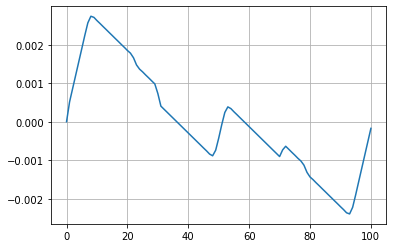

In [151]:
plt.plot(y.T[100])
plt.grid()

In [86]:
y0

array([0.00000000e+00, 3.14158749e-03, 6.28314397e-03, ...,
       6.28314397e-03, 3.14158749e-03, 1.22464680e-16])

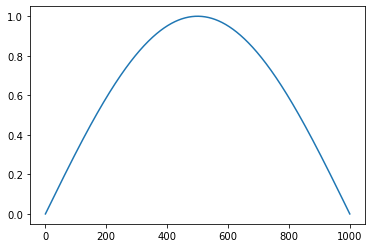

In [87]:
plt.plot(y0)